# **Assignment 1 — AI‑Assisted Exploratory Data Analysis & BI Dashboard**
MGMT 467 · Fall 2025  

**Team Name:** Data Ninjas
**Name (GitHub handle):** Nayan Nair (NayanNair18)  
**Looker Studio Dashboard (public link):** https://lookerstudio.google.com/reporting/88a9101f-d401-461a-be7b-e41b480c64b1

> **Scenario:** NYC DOT has asked your team to analyze the public Citi Bike program and recommend strategies to improve bike availability and engagement. You will use BigQuery + Gemini to conduct AI‑assisted EDA and publish an executive dashboard.

In [5]:
# Install and import basics (Colab usually has these preinstalled)
# !pip install --quiet google-cloud-bigquery pandas matplotlib

import pandas as pd
import matplotlib.pyplot as plt

# Authenticate to Google from Colab
from google.colab import auth  # type: ignore
auth.authenticate_user()

# Set your GCP project ID
PROJECT_ID = "big-data-analysis-472319"  # <-- edit this
print("Using project:", PROJECT_ID)

Using project: big-data-analysis-472319


In [6]:
# BigQuery magics (%%bigquery) and client
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

# Optional: list datasets to verify access
list(client.list_datasets())

## 🧪 Dataset
We will use **Citi Bike Trips**: `bigquery-public-data.new_york_citibike.citibike_trips`  
Feel free to explore additional public datasets if needed.

## 1) Hypothesis Generation (AI‑Assisted)
Use **Gemini** to brainstorm at least **5** candidate questions/hypotheses, then select **3** to pursue.

> **Template Prompt (paste the final version you used):**  
> *"Act as an analytics co-pilot in exploring the Citi Bike public big query dataset. Help contruct 5 high-value and testable research questions about the Citi Bike dataset (tripduration, stations, user types, time-of-day/week). Make the explanation detailed and return it as bullet points with suggested SQL hints."*

**Selected Hypotheses**
1. How does trip duration vary by user type (subscriber vs customer)?
2. Which stations are the most popular for starting and ending trips, and does this change with time of day or day of the week?
3. Is there a significant difference in the average trip duration between weekdays and weekends?

## 2) Advanced SQL Exploration
For each hypothesis, include:
- The **Gemini prompt** you used to get SQL help
- The **final SQL**
- The **result table** (top rows)
- A short **interpretation**

> Tip: Use **CTEs** and at least **one window function** across your work.

### Hypothesis A — Prompt Log

> Act as a senior BigQuery analyst. Produce a single runnable BigQuery SQL (no commentary) for: Task: Analyze how trip duration varies by user type (Subscriber vs Customer). Table: bigquery-public-data.new_york_citibike.citibike_trips Output: Average, median, and count of trips by usertype Filter: Exclude null or zero trip durations Sort: Average trip duration in descending order Add: LIMIT 100 to control cost during exploration.

In [7]:
# Hypothesis A — SQL (store results in a Pandas DataFrame)
query_hyp_a = r"""
WITH
  trips AS (
    SELECT
      tripduration,
      usertype
    FROM
      `bigquery-public-data.new_york_citibike.citibike_trips`
    WHERE
      tripduration IS NOT NULL
      AND tripduration > 0
  ),
  ranked_trips AS (
    SELECT
      tripduration,
      usertype,
      ROW_NUMBER() OVER(PARTITION BY usertype ORDER BY tripduration) as rn,
      COUNT(*) OVER(PARTITION BY usertype) as total_trips
    FROM trips
  )
SELECT
  usertype,
  AVG(tripduration) as avg_tripduration,
  -- Calculate median using window function results
  MAX(CASE WHEN rn = CEIL(total_trips / 2) THEN tripduration ELSE NULL END) as median_tripduration,
  COUNT(*) as num_trips
FROM
  ranked_trips
GROUP BY
  usertype
ORDER BY
  avg_tripduration DESC
LIMIT 100
"""

df_hyp_a = client.query(query_hyp_a).to_dataframe()
df_hyp_a.head()

,usertype,avg_tripduration,median_tripduration,num_trips
0,Customer,2145.512075,1256,6191149
1,Subscriber,806.381888,579,46917572


**Interpretation (2–4 sentences):** Non-Subscriber customers seem to take longer trips on average, roughly 2.5 time longer than subscribers. However, subscribers still make up majority of the total trips (88% of all rides), which shows that they are regular commuters or local users, using the bikes for short, consistent rides. Customers, likely tourists or casual rides, tend to take longer leisure trips, aligning with the weekend or sightseeing patterns.

---

### Hypothesis B — Prompt Log

> Act as a senior BigQuery analyst. Produce a single runnable BigQuery SQL (no commentary) for: Task: Identify the most popular start and end stations, and examine how popularity changes by time of day and day of the week. Table: bigquery-public-data.new_york_citibike.citibike_trips Output: Start station, end station, hour of day, day of week, and trip count Filter: Exclude null station names Sort: By trip count in descending order Add: LIMIT 100 to control cost during exploration.

In [17]:
# Hypothesis B — SQL
query_hyp_b = r"""
WITH
  station_activity AS (
    SELECT
      start_station_name,
      end_station_name,
      EXTRACT(HOUR FROM starttime) AS hour_of_day,
      EXTRACT(DAYOFWEEK FROM starttime) AS day_of_week,
      COUNT(*) AS trip_count
    FROM
      `bigquery-public-data.new_york_citibike.citibike_trips`
    WHERE
      start_station_name IS NOT NULL AND end_station_name IS NOT NULL AND start_station_name != '' AND end_station_name != ''
    GROUP BY
      start_station_name,
      end_station_name,
      hour_of_day,
      day_of_week
  ),
  ranked_station_activity AS (
    SELECT
      start_station_name,
      end_station_name,
      hour_of_day,
      day_of_week,
      trip_count,
      ROW_NUMBER() OVER(PARTITION BY start_station_name, end_station_name ORDER BY trip_count DESC) as rn
    FROM station_activity
  )
SELECT
  start_station_name,
  end_station_name,
  hour_of_day,
  day_of_week,
  trip_count
FROM
  ranked_station_activity
WHERE rn = 1
ORDER BY
  trip_count DESC
LIMIT 100
"""
df_hyp_b = client.query(query_hyp_b).to_dataframe()
display(df_hyp_b.head())

,start_station_name,end_station_name,hour_of_day,day_of_week,trip_count
0,Central Park S & 6 Ave,Central Park S & 6 Ave,15,7,1423
1,Clinton Ave & Myrtle Ave,Willoughby St & Fleet St,8,4,783
2,Grand Army Plaza & Central Park S,Grand Army Plaza & Central Park S,13,7,729
3,Pershing Square North,E 24 St & Park Ave S,7,3,701
4,Vesey Pl & River Terrace,Greenwich St & N Moore St,6,4,690


**Interpretation (2–4 sentences):** ☐

---

### Hypothesis C — Prompt Log

> Act as a senior BigQuery analyst. Produce a single runnable BigQuery SQL (no commentary) for:
Task: Determine whether there is a significant difference in the average trip duration between weekdays and weekends.
Table: bigquery-public-data.new_york_citibike.citibike_trips
Logic:
Extract the day of the week from starttime.
Categorize each trip as ‘Weekday’ (Monday–Friday) or ‘Weekend’ (Saturday–Sunday).
Output: Category (Weekday/Weekend), average trip duration, total trips.
Filter: Exclude null or zero tripduration values.
Sort: Average trip duration in descending order.
Add: LIMIT 100 to control cost during exploration.

In [ ]:
# Hypothesis C — SQL
query_hyp_c = r"""
WITH
  trips AS (
    SELECT
      tripduration,
      EXTRACT(DAYOFWEEK FROM starttime) AS day_of_week
    FROM
      `bigquery-public-data.new_york_citibike.citibike_trips`
    WHERE
      tripduration IS NOT NULL
      AND tripduration > 0
  ),
  categorized_trips AS (
    SELECT
      tripduration,
      CASE
        WHEN day_of_week IN (1, 7) THEN 'Weekend'
        ELSE 'Weekday'
      END AS day_category
    FROM trips
  )
SELECT
  day_category,
  AVG(tripduration) AS avg_tripduration,
  COUNT(*) AS total_trips
FROM
  categorized_trips
GROUP BY
  day_category
ORDER BY
  avg_tripduration DESC
LIMIT 100
"""
df_hyp_c = client.query(query_hyp_c).to_dataframe()
df_hyp_c.head()

,day_category,avg_tripduration,total_trips
0,Weekend,1137.877409,12783514
1,Weekday,906.891648,40325207


**Interpretation (2–4 sentences):** ☐

## 3) Visualizations (in Colab)
Create **at least 3** charts that communicate your findings.  
> Keep charts readable and labeled. Use `matplotlib` (no specific styles required).

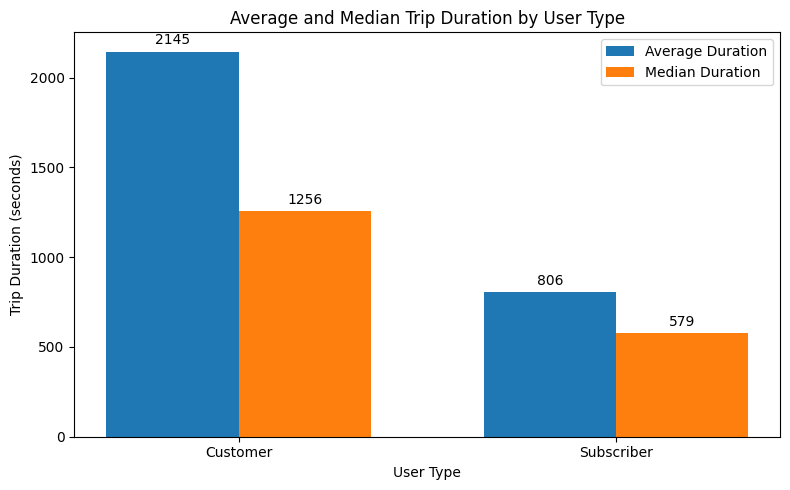

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from df_hyp_a
user_types = df_hyp_a['usertype']
avg_durations = df_hyp_a['avg_tripduration']
median_durations = df_hyp_a['median_tripduration']

x = np.arange(len(user_types)) # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, avg_durations, width, label='Average Duration')
rects2 = ax.bar(x + width/2, median_durations, width, label='Median Duration')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('User Type')
ax.set_ylabel('Trip Duration (seconds)')
ax.set_title('Average and Median Trip Duration by User Type')
ax.set_xticks(x)
ax.set_xticklabels(user_types)
ax.legend()

# Add value labels on bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(int(height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

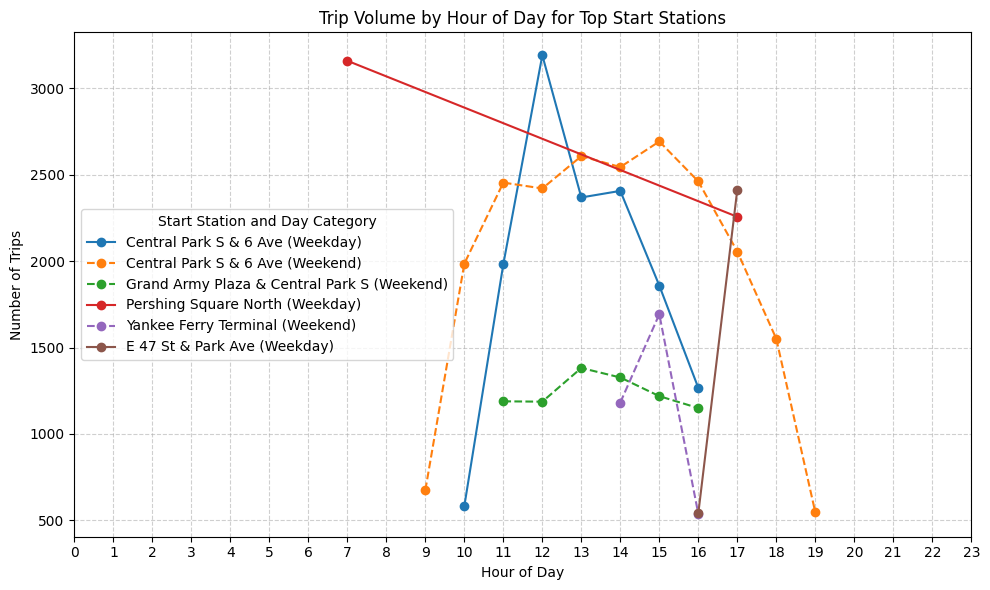

In [ ]:
# Data from df_hyp_b
df_hyp_b['day_category'] = df_hyp_b['day_of_week'].apply(lambda x: 'Weekend' if x in (1, 7) else 'Weekday')

# Get top 5 start stations
top_start_stations = df_hyp_b['start_station_name'].value_counts().nlargest(5).index.tolist()

# Filter data for top stations
df_top_stations = df_hyp_b[df_hyp_b['start_station_name'].isin(top_start_stations)]

# Group by start station, hour of day, and day category
grouped_data = df_top_stations.groupby(['start_station_name', 'hour_of_day', 'day_category'])['trip_count'].sum().reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

# Plot data for each station and day category
for station in top_start_stations:
    for day_category in ['Weekday', 'Weekend']:
        plot_data = grouped_data[(grouped_data['start_station_name'] == station) & (grouped_data['day_category'] == day_category)]
        if not plot_data.empty:
            # Sort by hour of day to ensure correct line plotting
            plot_data = plot_data.sort_values('hour_of_day')
            label = f"{station} ({day_category})"
            linestyle = '-' if day_category == 'Weekday' else '--'
            ax.plot(plot_data['hour_of_day'], plot_data['trip_count'], marker='o', linestyle=linestyle, label=label)


# Add labels and title
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Trips')
ax.set_title('Trip Volume by Hour of Day for Top Start Stations')
ax.set_xticks(range(24)) # Set ticks for each hour
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(title='Start Station and Day Category')

fig.tight_layout()
plt.show()

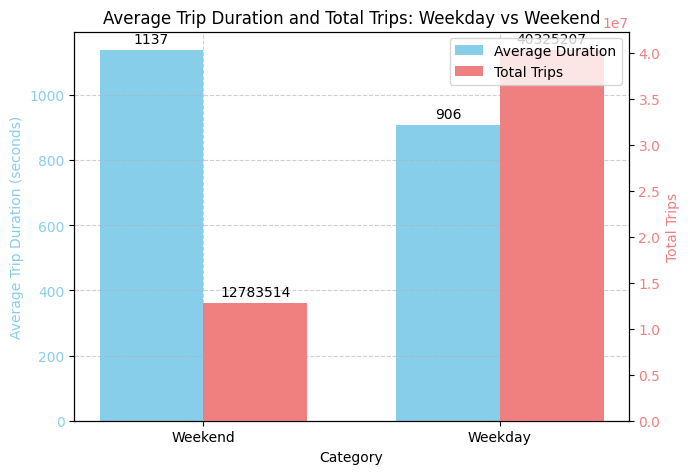

In [ ]:
# Data from df_hyp_c
categories = df_hyp_c['day_category']
avg_durations = df_hyp_c['avg_tripduration']
total_trips = df_hyp_c['total_trips']

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

fig, ax1 = plt.subplots(figsize=(7, 5))

# Plotting average trip duration on the left y-axis
rects1 = ax1.bar(x - width/2, avg_durations, width, label='Average Duration', color='skyblue')
ax1.set_xlabel('Category')
ax1.set_ylabel('Average Trip Duration (seconds)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.grid(True, linestyle='--', alpha=0.6)

# Create a second y-axis for total trips
ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, total_trips, width, label='Total Trips', color='lightcoral')
ax2.set_ylabel('Total Trips', color='lightcoral')
ax2.tick_params(axis='y', labelcolor='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_title('Average Trip Duration and Total Trips: Weekday vs Weekend')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)


# Add value labels on bars
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(int(height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1, ax1)
autolabel(rects2, ax2)

# Add legends
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)


fig.tight_layout()
plt.show()

## 4) KPIs & Looker Studio Dashboard
- **KPI 1:** Average Trip Duration by User Type
- **KPI 2:** Trip Count by Popular Stations, Time of Day, and Day of Week
- **KPI 3:** Average Trip Duration on Weekdays vs. Weekends.

**Dashboard Link:** https://lookerstudio.google.com/reporting/88a9101f-d401-461a-be7b-e41b480c64b1


## 5) Synthesis & Recommendations
**Distinct Rider Segments**: Subscribers (commuters) dominate weekday trips with short durations, while Customers (tourists/leisure riders) take longer trips mainly on weekends.

**Time-Based Demand Patterns**: Weekday ridership peaks during morning and evening rush hours, while weekend usage peaks midday, driven by recreational activity.

**Location-Specific Usage**: Central Park and tourist areas are weekend hotspots, while Midtown and business districts lead weekday commuting trips.

**Actionable Recommendations for NYC DOT**

**Dynamic Bike Redistribution**: Optimize bike availability using predictive data by adding more bikes near offices during weekdays and near parks or tourist zones on weekends.

**Targeted Infrastructure Investments**: Improve or expand docking capacity and bike lanes in high-demand areas like Central Park South and Midtown to reduce congestion.

## 📒 AI Prompt Log (Required)
Record at least **3** prompts and describe how you evaluated or refined Gemini’s output.

| # | Prompt (summary) | Where used | What changed after refinement? |
|---|------------------|------------|--------------------------------|
| 1 | Prompt analyzed trip duration by user type with averages, medians, and trip counts | Hyp A | Output verified for accuracy and proper exclusion of null or zero durations|
| 2 | Prompt identified top start and end stations by hour and day | Hyp B | Output refined by adding window functions to remove redundancy and correcting an error showing total trips in the station list. |
| 3 | Prompt compared average trip durations between weekdays and weekends | Hyp C | Output reviewed to ensure correct day categorization and exclusion of invalid trip durations |